[View in Colaboratory](https://colab.research.google.com/github/brynmwangy/predicting-bitcoin-prices-using-LSTM/blob/master/btc.ipynb)

In [252]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from collections import OrderedDict

import io
%matplotlib inline


In [253]:
#we now define the network
#Hyperparameters used in the network
batch_size = 8 #how many windows of data we are passing at once
window_size_en = 12 #how b5window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 # How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.0001 
epochs = 120
training_test_blocks=5

In [254]:
#decoding the files as uploaded will be a dictionary of keys (the file names) and values (the encoded file objects)
# eu = pd.read_csv('./us_euro_daily_exrate.csv')
# master_test = pd.read_csv('./master_test.csv') #, parse_dates=[0])
eu_ex = pd.read_csv('./data/us_euro_daily_exrate.csv', parse_dates=[0])
us_int = pd.read_csv('./data/us_daily_interest_rate.csv',  parse_dates=[0])
eu_int = pd.read_csv('./data/eu_daily_interest_rate.csv',  parse_dates=[0])
oil_iex = pd.read_csv('./data/US_oil_ie_weekly.csv',  parse_dates=[0])
# master_data = pd.read_csv('./data/monthly_master_data.csv', parse_dates=[0])

In [255]:
# master_data_use = master_data.drop(['DATA_MONTH','EU_CPI','US_CPI'], axis = 1)

In [256]:
master_test = eu_ex.set_index(eu_ex['Date'])
master_test = master_test.join(us_int.set_index(us_int['DATE']))
master_test = master_test.drop(['Date', 'DATE'], axis = 1)
master_test = master_test.join(eu_int.set_index(eu_int['Date']))
master_test = master_test.drop(['Country', 'Date'], axis = 1)
master_test = master_test[~master_test['USintRate'].isnull()]


In [257]:
master_test = master_test[~(master_test['USintRate']=='.')]
#.astype(float)
master_test = master_test[~master_test['Rate'].isnull()]

In [258]:
master_test=master_test.astype(float)

In [259]:
oil_iex.columns

Index(['Date', 'Import Energy', 'Export Energy'], dtype='object')

In [260]:
master_test=master_test.join(oil_iex.set_index('Date'))
master_test=master_test[~master_test['Import Energy'].isnull()]

In [261]:
#master_test.to_csv('./data/mf_weekly_data_use.csv')

In [262]:
#selecting only the column that we are going to use in the prediction process

#data_to_use=btc['Value'].values
# data_df = eu[~eu['Value'].isnull()]
# eu_rates = data_df['Value'].astype(float)


# eu_rates = eu['Value'].astype(float)
# master_clean=master_test[(master_test['Year'] > 2000) & (master_test['Year'] <2019)]
# master_clean=master_clean.drop(['year','YEAR', 'Year'], axis=1)
# master_clean
# data_to_use = master_clean[['EXRATEUSEU', 'IYR', 'EYR', 'USDBarrel', 'USintRate']]
# data_to_use = master_data_use
data_to_use = master_test

In [263]:
data_to_use[data_to_use.isnull()==True].count()

Rate             0
USintRate        0
EUInterest       0
Import Energy    0
Export Energy    0
dtype: int64

In [264]:
data_to_use.tail()

,Rate,USintRate,EUInterest,Import Energy,Export Energy
Date,,,,,
2017-10-27,0.8636,0.98,-0.4,9629.0,7678.0
2017-11-03,0.8609,1.02,-0.4,9550.0,5854.0
2017-11-17,0.8475,1.08,-0.4,9795.0,7012.0
2017-11-24,0.8378,1.14,-0.4,9100.0,7328.0
2017-12-01,0.8396,1.14,-0.4,9170.0,6399.0


In [265]:
type(data_to_use)

pandas.core.frame.DataFrame

In [266]:
data_to_use.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 822 entries, 2001-08-03 to 2017-12-01
Data columns (total 5 columns):
Rate             822 non-null float64
USintRate        822 non-null float64
EUInterest       822 non-null float64
Import Energy    822 non-null float64
Export Energy    822 non-null float64
dtypes: float64(5)
memory usage: 38.5 KB


In [267]:
data_to_use.index

DatetimeIndex(['2001-08-03', '2001-08-10', '2001-08-17', '2001-08-24',
               '2001-08-31', '2001-09-07', '2001-09-14', '2001-09-21',
               '2001-09-28', '2001-10-05',
               ...
               '2017-09-22', '2017-09-29', '2017-10-06', '2017-10-13',
               '2017-10-20', '2017-10-27', '2017-11-03', '2017-11-17',
               '2017-11-24', '2017-12-01'],
              dtype='datetime64[ns]', name='Date', length=822, freq=None)

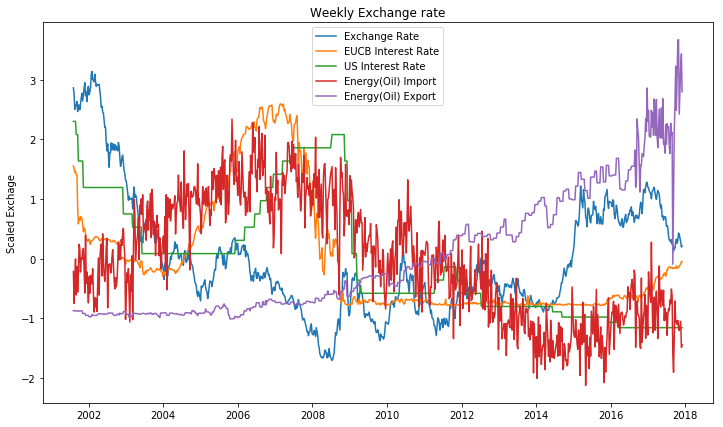

In [268]:
#data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use)
#scaled_data = scaler.fit_transform(data_to_use['Value'].values.reshape(-1, 1))
# scaled_data = scaler.fit_transform(data_to_use['EXRATEUSEU'].values.reshape(-1, 1))
# scaled_weekly_data = scaler.fit_transform(eu_weekly_arr_to_use.reshape(-1, 1))
# scaled_monthly_data = scaler.fit_transform(eu_monthly_arr_to_use.reshape(-1, 1))
# scaled_yearly_data = scaler.fit_transform(eu_yearly_arr_to_use.reshape(-1, 1))


#plotting the data
import matplotlib.pyplot as plt
labels=['Exchange Rate', 'EUCB Interest Rate', 'US Interest Rate', "Energy(Oil) Import", "Energy(Oil) Export"]
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')

plt.title('Weekly Exchange rate')
#plt.xlabel('Weekly')
plt.ylabel('Scaled Exchage')
plt.plot(data_to_use.index,scaled_data)
plt.legend(labels, loc='upper center')
# plt.plot(scaled_weekly_data, label='Weekly Rate')
# plt.plot(scaled_monthly_data, label = 'Monthly Rate')
# plt.plot(scaled_yearly_data, label = 'Monthly Rate')
#plt.legend()
plt.show()

In [269]:
# data_df = eu[~eu['Value'].isnull()]
# eu_rates = data_df['Value'].astype(float)
# # eu_rates = eu['Value'].astype(float)
# data_to_use=eu_rates.values
# data_to_use

scaled_data = scaler.fit_transform(data_to_use)
# scaled_data = scaler.fit_transform(data_to_use[0:8])
len(data_to_use)
#scaled_data


822

In [270]:
# eu['Value']=eu['Value'].fillna(eu['Value'].mean())
# eu_rates = eu['Value'].astype(float)
# data_to_use=eu_rates.values
# data_to_use

In [271]:
# eu[eu['Value'].isnull()]

In [272]:
# check len(X) mod has NO remainder
def check_batch_size(len_X_train):
    if ((len_X_train % batch_size) > 0): 
        print('Waring for partial batch size problem.  Will lost last partial batch data')
        print('X train size : ', len_X_train, 'Batch size : ', batch_size)

In [273]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, window_size_en)


#we now split the data into training and test set
import numpy as np
test_portion = len(X) // training_test_blocks
train_i = len(X) - test_portion

# X_train  = np.array(X[:1018])
# y_train = np.array(y[:1018])

# X_test = np.array(X[1018:])
# y_test = np.array(y[1018:])

X_train  = np.array(X[:train_i])
y_train = np.array(y[:train_i])

X_test = np.array(X[train_i:])
y_test = np.array(y[train_i:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))
check_batch_size(len(X_train))

X_train size: (648, 12, 5)
y_train size: (648, 5)
X_test size: (162, 12, 5)
y_test size: (162, 5)


In [274]:
test_portion, len(X), training_test_blocks

(162, 810, 5)

In [275]:
input_dimension = len(X_train[0][0])

In [276]:
input_dimension

5

In [277]:
#we define the placeholders
#(a Tensorflow variable) of the dimensions [batch_size, sequence_length, input_dimension] 
# inputs = tf.placeholder(tf.float32, [batch_size, window_size_en, 1])
# targets = tf.placeholder(tf.float32, [batch_size, 1])

inputs = tf.placeholder(tf.float32, [batch_size, window_size_en, input_dimension])
targets = tf.placeholder(tf.float32, [batch_size, input_dimension])



#weights and implementation of LSTM cell
# LSTM weights

#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):
    
# LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
#     input -> tf.reshape(inputs[i][ii], (-1, 1))
#     output -> batch_state
#     state -> batch_output
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    #output prediction
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output
  
  
 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
  
    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros 
    #at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size_en):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
    print ('batch_output - > ', batch_output)   
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs 

batch_output - >  Tensor("mul_203:0", shape=(5, 256), dtype=float32)
batch_output - >  Tensor("mul_239:0", shape=(5, 256), dtype=float32)
batch_output - >  Tensor("mul_275:0", shape=(5, 256), dtype=float32)
batch_output - >  Tensor("mul_311:0", shape=(5, 256), dtype=float32)
batch_output - >  Tensor("mul_347:0", shape=(5, 256), dtype=float32)
batch_output - >  Tensor("mul_383:0", shape=(5, 256), dtype=float32)
batch_output - >  Tensor("mul_419:0", shape=(5, 256), dtype=float32)
batch_output - >  Tensor("mul_455:0", shape=(5, 256), dtype=float32)


[<tf.Tensor 'add_636:0' shape=(5, 1) dtype=float32>,
 <tf.Tensor 'add_745:0' shape=(5, 1) dtype=float32>,
 <tf.Tensor 'add_854:0' shape=(5, 1) dtype=float32>,
 <tf.Tensor 'add_963:0' shape=(5, 1) dtype=float32>,
 <tf.Tensor 'add_1072:0' shape=(5, 1) dtype=float32>,
 <tf.Tensor 'add_1181:0' shape=(5, 1) dtype=float32>,
 <tf.Tensor 'add_1290:0' shape=(5, 1) dtype=float32>,
 <tf.Tensor 'add_1399:0' shape=(5, 1) dtype=float32>]

In [278]:
len(X_train)

648

In [279]:
#we define the loss
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
log_timestamp = {}
for i in range(epochs):
    traind_scores = []
    epoch_loss = []
    ii = 0

    while(ii + batch_size) <= len(X_train):
#        print(ii, " : <- ii + batch_size ->: ", (ii + batch_size))
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]    
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        log_timestamp[datetime.datetime.now()] = c
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
#        print(ii, " : -- ii + batch_size --: ", (ii + batch_size))
    if ((i % 10) == 0 or (i==(epochs-1))):
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
        

Epoch 0/120  Current loss: 0.6355317831039429
Epoch 10/120  Current loss: 0.05774376168847084
Epoch 20/120  Current loss: 0.05007106438279152
Epoch 30/120  Current loss: 0.046320583671331406
Epoch 40/120  Current loss: 0.04383176192641258
Epoch 50/120  Current loss: 0.042119402438402176
Epoch 60/120  Current loss: 0.04084025323390961
Epoch 70/120  Current loss: 0.039866480976343155
Epoch 80/120  Current loss: 0.03921917453408241
Epoch 90/120  Current loss: 0.03886156901717186
Epoch 100/120  Current loss: 0.038685668259859085
Epoch 110/120  Current loss: 0.03859192505478859
Epoch 119/120  Current loss: 0.03853103145956993


In [280]:
len(log_timestamp)/epochs

81.0

In [281]:
sup_exrate =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
#        print(len(traind_scores[i]))
        sup_exrate.append(traind_scores[i][j][0])
sup_euro_int =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup_euro_int.append(traind_scores[i][j][1])
sup_us_int = []
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup_us_int.append(traind_scores[i][j][2])

sup_oil_im = []
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup_oil_im.append(traind_scores[i][j][2])
    
sup_oil_ex = []
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup_oil_ex.append(traind_scores[i][j][2])

In [282]:
tests = []
i = 0
while i+batch_size <= len(X_test): 
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
#    o = session.run(outputs,feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [283]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])


In [284]:
# data_to_use.tail()
# data_to_use.index.values

In [285]:
#test_new_inverse = scaler.inverse_transform(tests_new[len(tests_new)-1])
#c = tests_new[len(tests_new)-1].reshape(1,-1)
c = tests_new[len(tests_new)-1].reshape(1,-1)
a = test_new_inverse = scaler.inverse_transform(c)
a

array([[ 8.5514390e-01,  9.7351146e-01, -4.2795339e-01,  9.6690811e+03,
         6.1465645e+03]], dtype=float32)

In [286]:
#traind_scores
def testd_data_set(tests_new_ex, feature_nloc):
    f_temp_sup_test = []
    for i in range(len(tests_new_ex)):
        for j in range(len(tests_new_ex[i])):
    #        print(len(traind_scores[i]))
            f_temp_sup_test.append(tests_new_ex[i][j][feature_nloc])
#             u_sup_test.append(tests_new_ex[i][j][1])
#             e_sup_test.append(tests_new_ex[i][j][2])
    # sup_test
    temp_sup_test=[]
    temp_test_set=[]
    for e in range(train_i) : temp_sup_test.append(None)
    #for e in p_sup_test: 
    
    for e in f_temp_sup_test: 
        temp_test_set.append(e)
        temp_sup_test.append(e)
    
    return temp_sup_test, temp_test_set

In [287]:
#traind_scores
#tests_new
#quick fixed output data extra list layer issue
tests_new_ex = [tests_new]
# tests_new_ex
p_sup_test, p_test = testd_data_set(tests_new_ex, 0)
e_sup_test, u_test = testd_data_set(tests_new_ex, 1)
u_sup_test, e_test = testd_data_set(tests_new_ex, 2)
o_ex_sup_test, o_im_test = testd_data_set(tests_new_ex, 3)
o_im_sup_test, o_ex_test = testd_data_set(tests_new_ex, 4)


In [288]:
# rmse = sqrt(mean_squared_error(y_actual, y_predict))
#mean_squared_error(scaled_data[train_i:,0],p_sup_test[train_i:])
rmse_exrate_data = scaled_data[:,0]
rmse_us_int_data = scaled_data[:,1]
rmse_eu_int_data = scaled_data[:,2]
rmse_o_im_data = scaled_data[:,3]
rmse_o_ext_data = scaled_data[:,4]

idx = len(o_im_test)
rmse_exrate = sqrt(mean_squared_error(rmse_exrate_data[(len(rmse_exrate_data)-idx):], p_test))
rmse_us_int = mean_squared_error(rmse_us_int_data[(len(rmse_us_int_data)-idx):], u_test)
rmse_eu_int = mean_squared_error(rmse_eu_int_data[(len(rmse_eu_int_data)-idx):], e_test)
rmse_oil_im = mean_squared_error(rmse_o_im_data[(len(rmse_o_im_data)-idx):], o_im_test)
rmse_oil_ex = mean_squared_error(rmse_o_ext_data[(len(rmse_o_ext_data)-idx):], o_ex_test)


In [289]:
# len(p_test),
date_list = data_to_use.index.values[(len(rmse_exrate_data)-idx):]

In [290]:
#o_ex_sup_test[::-1]


#df_test_scores = pd.DataFrame(p_test)#, e_test, u_test, o_im_test, o_ex_test])
ordered_data = OrderedDict([ 
          ('Year', date_list),
          ('EUUSDExRate', p_test),
          ('USRate',      e_test),
          ('EURate',      u_test),
          ('EngImport',   o_im_test),
          ('EngExport',   o_ex_test) 
])


df_test_scores = pd.DataFrame.from_dict(ordered_data)
# df_test_scores.to_csv('./data/test_scores.csv')

In [291]:
#df_test_scores = df_test_scores[['EUUSDExRate']].astype(float)

In [292]:
#df_test_scores.plot()

In [293]:
#temp = df_test_scores['Year']
#df_test_scores = df_test_scores[['EUUSDExRate','USRate', 'EURate', 'EngImport', 'EngExport']].astype(float)
df_test_scores = df_test_scores[['EUUSDExRate','USRate', 'EURate']].astype(float)
df_test_scores_exrate = df_test_scores['EUUSDExRate']
df_test_scores_us_int = df_test_scores['USRate']
df_test_scores_eu_int = df_test_scores['EURate']

In [294]:
y_test[:,0]

array([-0.5080477 , -0.40513903, -0.40422833, -0.33865821, -0.25487416,
       -0.15834037, -0.22664258, -0.2940341 , -0.24849929, -0.16562594,
       -0.1027879 , -0.14467993, -0.08639537, -0.11189487, -0.0326643 ,
       -0.13921575,  0.00922772,  0.14583215,  0.26422265,  0.47368276,
        0.64034016,  0.6321439 ,  0.60391232,  0.54927055,  0.57477004,
        0.69953541,  0.95544103,  1.21954292,  1.00461863,  0.92812015,
        0.85253237,  1.15943697,  1.01372559,  0.9399592 ,  0.7013568 ,
        0.66766105,  0.53469941,  0.820658  ,  0.84980028,  0.76510554,
        0.64125086,  0.60026953,  0.72958839,  0.73414187,  0.96090521,
        0.86346072,  0.82430079,  0.87712116,  0.76328414,  0.58569839,
        0.71774934,  0.75781997,  0.59844814,  0.583877  ,  0.7031782 ,
        0.64216155,  0.58023422,  0.5829663 ,  0.83340775,  0.81337243,
        1.04104647,  1.06017109,  1.10934868,  1.16125836,  0.93358432,
        0.84342541,  0.96181591,  0.93267363,  0.87256768,  0.98

Text(0, 0.5, 'Scaled Exchange Values')

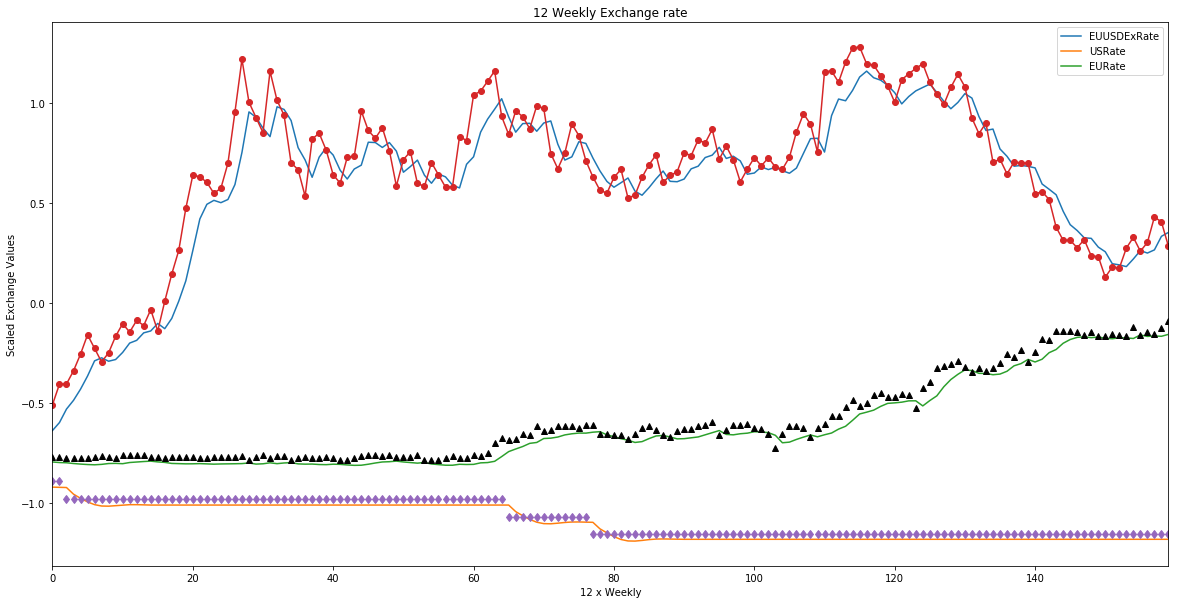

In [295]:
# date ploting issue
# df_test_scores['Date'] = temp
#temp

df_test_scores.plot(figsize=(20,10))
plt.plot(y_test[:,0], '-o', label="actual exchange rate")
plt.plot(y_test[:,1], 'k^', label="actual US interest rate")
plt.plot(y_test[:,2], 'd', label="actual EU interest rate")

plt.title(str(window_size_en) + ' Weekly Exchange rate')
plt.xlabel(str(window_size_en) + ' x Weekly')
plt.ylabel('Scaled Exchange Values')


In [296]:
df_test_scores_exrate.head()

0   -0.637185
1   -0.597152
2   -0.529782
3   -0.486140
4   -0.430262
Name: EUUSDExRate, dtype: float64

Text(0, 0.5, 'Scaled Exchange Values')

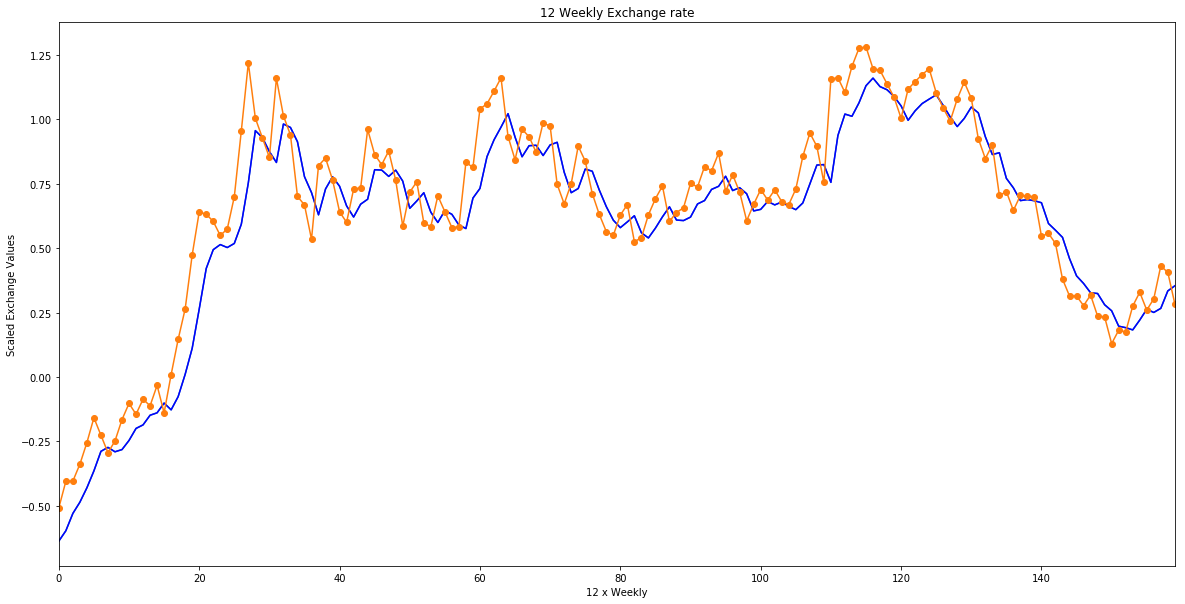

In [297]:
df_test_scores_exrate.plot(figsize=(20,10))
df_test_scores_exrate.plot(color='blue')
plt.plot(y_test[:,0], '-o', label="actual exchange rate")
#df_ex_ma30.plot(color='blue')
#plt.plot(df_ex_ma30)
plt.title(str(window_size_en) + ' Weekly Exchange rate')
plt.xlabel(str(window_size_en) + ' x Weekly')
plt.ylabel('Scaled Exchange Values')


Text(0, 0.5, 'Scaled Exchange Values')

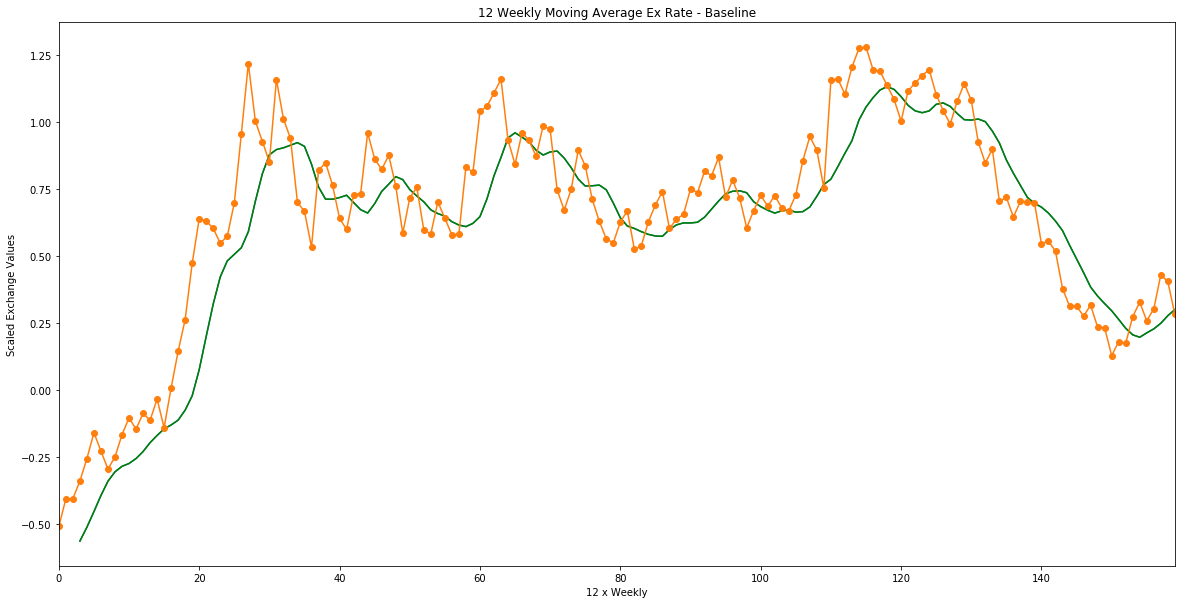

In [298]:
df_ex_ma30 = df_test_scores_exrate.rolling(window=4).mean()
df_ex_ma30.plot(figsize=(20,10))
df_ex_ma30.plot(color='green')
plt.plot(y_test[:,0], '-o')
plt.title(str(window_size_en) + ' Weekly Moving Average Ex Rate - Baseline')
plt.xlabel(str(window_size_en) + ' x Weekly')
plt.ylabel('Scaled Exchange Values')


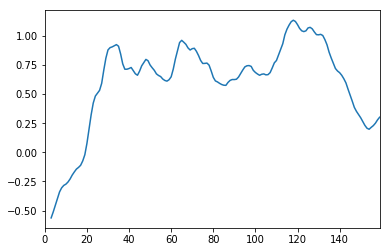

In [299]:
#df_test_scores_exrate
df_ex_ma30.plot()

In [300]:
rmse_exrate, rmse_eu_int, rmse_us_int, rmse_oil_im, rmse_oil_ex

(0.1968132132887357,
 0.0009026379042023677,
 0.003720411732071141,
 0.1442675588080876,
 0.20286197213976992)

In [301]:
#len(sup_test)
#scaled_data[:,0]

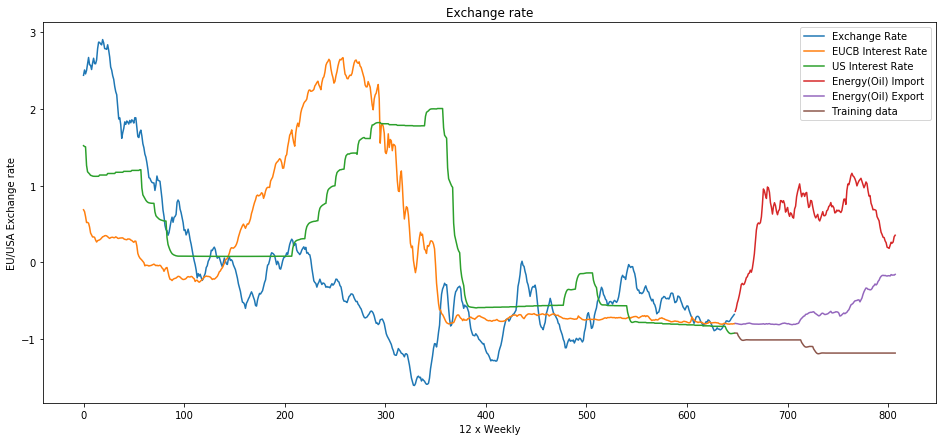

In [302]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Exchange rate')
plt.xlabel(str(window_size_en)+' x Weekly')
plt.ylabel('EU/USA Exchange rate')
#plt.plot(data_to_use.index,scaled_data)
plt.plot(sup_exrate)
plt.plot(sup_euro_int)
plt.plot(sup_us_int)
# plt.plot(sup_oil_ex)
# plt.plot(sup_oil_im)
plt.plot(p_sup_test)
plt.plot(e_sup_test)
plt.plot(u_sup_test)
# plt.plot(o_ex_sup_test)
# plt.plot(o_im_sup_test)
labels.append('Training data')
labels.append('Testing data')
plt.legend(labels, loc='upper right')
#plt.plot(t_n_new, label='Testing data')

# plt.legend()
plt.show()


In [46]:
y[len(y)-10:]

[array([ 0.17497442, -0.15843133, -1.15623524, -0.70831921,  2.58225259]),
 array([ 0.275151  , -0.16487106, -1.15623524, -1.06362793,  3.22488797]),
 array([ 0.32888207, -0.11979298, -1.15623524, -1.04673826,  2.48633687]),
 array([ 0.25966917, -0.15843133, -1.15623524, -1.09990945,  3.10362309]),
 array([ 0.30338258, -0.14555188, -1.15623524, -1.03547847,  3.66335987]),
 array([ 0.43088004, -0.15199161, -1.15623524, -1.15433174,  3.67363656]),
 array([ 0.40629125, -0.12623271, -1.15623524, -1.20374968,  2.42399164]),
 array([ 0.28425796, -0.08759436, -1.15623524, -1.05049152,  3.21735174]),
 array([ 0.19592044, -0.04895601, -1.15623524, -1.48524426,  3.43384724]),
 array([ 0.21231297, -0.04895601, -1.15623524, -1.44145622,  2.79737787])]

In [47]:
y_new_inverse = scaler.inverse_transform(y[len(y)-1])

In [48]:
y[len(y)-1]

array([ 0.21231297, -0.04895601, -1.15623524, -1.44145622,  2.79737787])

In [49]:
y_new_inverse

array([ 8.396e-01,  1.140e+00, -4.000e-01,  9.170e+03,  6.399e+03])

In [50]:
# X_new_inverse = scaler.inverse_transform(X[len(X)-1])
# tests


In [51]:
test_results = []
for e in range(train_i):
    tmp = np.empty((1,3))
    tmp[:] = None
    test_results.append(tmp)

# rest from train_i to the end of list
for i in range(len(tests_new)):
#    print("i-> :",i)
    test_results.append(tests_new[i])


In [52]:
test_results[len(test_results)-1]

array([[ 0.34467846],
       [-0.15255015],
       [-1.1690387 ],
       [-1.1088387 ],
       [ 3.258387  ]], dtype=float32)

In [53]:
#tests_new

In [356]:
# #traind_scores
# #tests_new
# #quick fixed output data extra list layer issue
# tests_new_ex = [tests_new]
# # tests_new_ex
# p_sup_test = []
# e_sup_test = []
# u_sup_test = []
# for i in range(len(tests_new_ex)):
#     for j in range(len(tests_new_ex[i])):
# #        print(len(traind_scores[i]))
#         p_sup_test.append(tests_new_ex[i][j][0])
#         u_sup_test.append(tests_new_ex[i][j][1])
#         e_sup_test.append(tests_new_ex[i][j][2])
# # sup_test

# sup_test=[]
# for e in range(train_i) : sup_test.append(None)
# #for e in p_sup_test: 
 
# for e in e_sup_test: 
#     sup_test.append(e)
